# Naive Bayes

In [57]:
classifier_naive_bayes_gaussian = GaussianNB()
classifier_naive_bayes_gaussian.fit(X_train_validation,y_train_validation) 
#Get training probabilities for probability calibration
probabilities_train = classifier_naive_bayes_gaussian.predict_proba(X_train_validation)[:,1]
#Calibrate probabilities with isotonic regression
ir.fit(probabilities_train,y_train_validation)                          
#Calibrate probabilities with platt's method
lr.fit(probabilities_train.reshape( -1, 1 ),y_train_validation) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
#Use the naive Bayes model on the test set and get uncalibrated probabilities
probabilities_test = classifier_naive_bayes_gaussian.predict_proba(X_test)[:,1]
#Use the cost sensitive threshold to predict the outcome
predictions_test_cost = [0 if x < threshold_cost else 1 for x in probabilities_test]
#Use the 50% threshold to predict the outcome
predictions_test_50 = [0 if x < threshold_05 else 1 for x in probabilities_test]
#Calibrate the probabilities by isotonic regression 
probas_calibrated_isotonic = ir.transform(probabilities_test)
#Use the cost sensitive threshold to predict the outcome
predictions_test_calibrated_isotonic_cost = [0 if x < threshold_cost else 1 for x in probas_calibrated_isotonic]
#Use the 50% threshold to predict the outcome
predictions_test_calibrated_isotonic_50 = [0 if x < threshold_05 else 1 for x in probas_calibrated_isotonic]
#Calibrate the probabilities by isotonic regression 
probas_calibrated_platt = lr.predict_proba(probabilities_test.reshape( -1, 1 ))[:,1]
#Use the cost sensitive threshold to predict the outcome
predictions_test_calibrated_platts_cost = [0 if x < threshold_cost else 1 for x in probas_calibrated_platt]
#Use the 50% threshold to predict the outcome
predictions_test_calibrated_platts_50 = [0 if x < threshold_05 else 1 for x in probas_calibrated_platt]

In [59]:
#Print the expected cost and the classification report for uncalibrated probabilities, 
#isotonic calibrated probabilities and platts calibrated probabilities
#with cost-sensitive threshold and 50% threshold
print('Uncalibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, predictions_test_cost))
print(classification_report(y_test, predictions_test_cost,target_names = ['Pay','Default']))
print('Uncalibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, predictions_test_50))
print(classification_report(y_test, predictions_test_50,target_names = ['Pay','Default']))
print('Isotonic calibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_isotonic_cost))
print(classification_report(y_test, predictions_test_calibrated_isotonic_cost,target_names = ['Pay','Default']))
print('Isotonic calibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_isotonic_50))
print(classification_report(y_test, predictions_test_calibrated_isotonic_50,target_names = ['Pay','Default']))
print('Platts calibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_platts_cost))
print(classification_report(y_test, predictions_test_calibrated_platts_cost,target_names = ['Pay','Default']))
print('Platts calibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_platts_50))
print(classification_report(y_test, predictions_test_calibrated_platts_50,target_names = ['Pay','Default']))
print('Dummy classifier: %i ' % expected_cost(y_test, clf_predictions))
print(classification_report(y_test, clf_predictions,target_names = ['Pay','Default']))

Uncalibrated probabilities, cost sensitive threshold: 3443 
             precision    recall  f1-score   support

        Pay       0.90      0.17      0.28      4663
    Default       0.24      0.94      0.39      1337

avg / total       0.76      0.34      0.31      6000

Uncalibrated probabilities, 50pct threshold: 3275 
             precision    recall  f1-score   support

        Pay       0.89      0.24      0.38      4663
    Default       0.25      0.90      0.40      1337

avg / total       0.75      0.39      0.39      6000

Isotonic calibrated probabilities, cost sensitive threshold: 2567 
             precision    recall  f1-score   support

        Pay       0.83      0.85      0.84      4663
    Default       0.43      0.41      0.42      1337

avg / total       0.74      0.75      0.75      6000

Isotonic calibrated probabilities, 50pct threshold: 2796 
             precision    recall  f1-score   support

        Pay       0.81      0.96      0.88      4663
    Default 

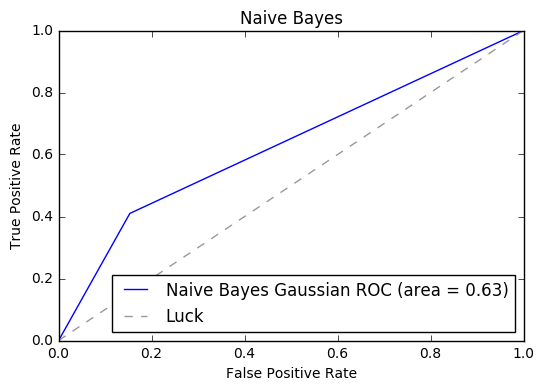

In [60]:
#Compute ROC curve and the area under the curve
#Start cross validation and draw the ROC curves
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
fpr, tpr, thresholds = roc_curve(y_test, predictions_test_calibrated_isotonic_cost)
mean_tpr += interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.figure(10)    
plt.plot(fpr, tpr, lw=1, label='Naive Bayes Gaussian ROC (area = %0.2f)' % roc_auc)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.title('Naive Bayes')
plt.legend(loc="lower right")
plt.savefig('Naive Bayes ROC')

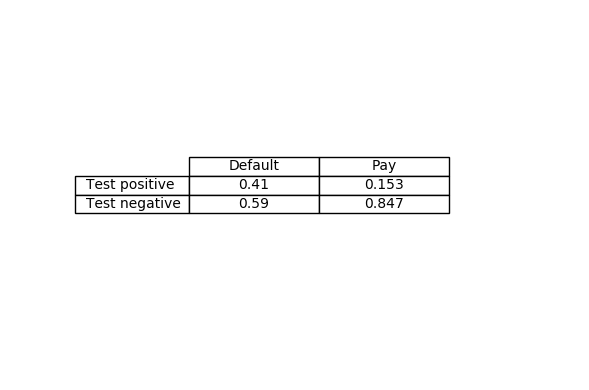

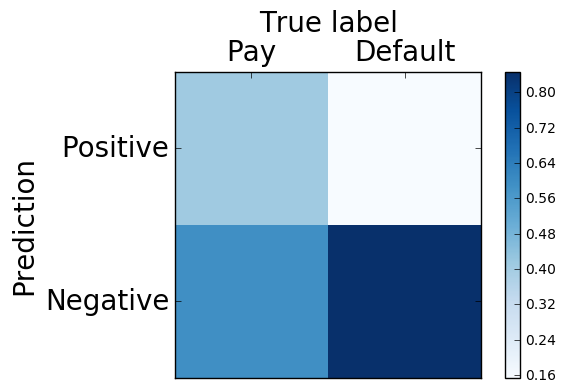

In [61]:
#Plot the confusion matrix 
cm = confusion_matrix_custom(y_test,predictions_test_calibrated_isotonic_cost)
cm = np.round(cm, decimals = 3)
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
ax.table(cellText=cm,
          rowLabels=['Test positive','Test negative'],
          colLabels=['Default','Pay'],
          cellLoc='center',colWidths=[0.25, 0.25],
          loc='center')
plt.tight_layout()

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap=plt.cm.Blues, interpolation='none')
fig.colorbar(im)
locs = np.arange(len(np.unique(y_test)))
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks(locs + 0.5)
ax.xaxis.set(ticks=locs, ticklabels=['Pay','Default'])
ax.yaxis.set_ticks(locs + 0.5)
ax.yaxis.set(ticks=locs, ticklabels=['Positive','Negative'])
plt.xlabel('True label', fontsize=20)
plt.ylabel('Prediction', fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
ax.grid(False) 